# 3 Usefulness
## 3.1 Predictive Model Performance
1. The original and synthetic evaluation samples are further divided into a test sample (90% of evaluation sample) and train sample (10% of evaluation sample). Categorical columns are one-hot-encoded, so all datas are numbers.  
2. A series of $ N $ commonly used predictive models (Random Forests, Linear Regression…) are trained on the train samples for both the real and the synthetic data and applied to the test samples. Suppose there are _n_ columns, the predictive model attempts to predict each column based on the rest _(n-1)_ of the columns. For different tasks, TSTR or TSTS & TRTR is applied.
    * TSTR: we calculate the error $ e_{i} $ (in this code we use MSE) for each column $ i $,  calculate the -- see _section II._
    $$
    E = \frac { \sum_{i=1}^{n} e_{i}}{n} 
    $$
        The lower the _E_, the better the synthetic data.
        
    * TSTS & TRTR: we calculate the error $ e_{i,j} $ (real) and $ e'_{i,j} $ (synthetic) for each column _i_ and predictive model _j_. There are two ways to compare TSTS and TRTR:      
        * We want to see if a model performs better than another model on the real data, whether or not it performs better on the synthetic data as well. We calculate $ E_{j} $ and $ E'_{j} $ for every model $ j $ and use a measuring quantity called $ SRA $ (Synthetic Ranking agreement) between lists $ (E)_{j=1}^{N} $ and $ (E')_{j=1}^{N} $  . SRA measures the proportion of agreed ranking, the higher the SRA, the better the synthetic data.  (see 1.3 for detailed explanation of SRA) -- see _section III._
       
        * We can also use SRA to measure the list of $ (e)_{i=1}^{n} $ for each column predicition results, for the specified model and synthetic data generator. -- see _section IV._
        * We want to see for a model $ j $, whether they generate similar error or not. We work 
        $$
        \epsilon _{j} = \sum_{i=1}^{n} (e_{i,j}-e'_{i,j})^2, 
        $$ 
          the lower the quantity, the better the synthetic data. -- see _section V._
          
* How to deal with 'NaN'?
    * For categorical columns which proportion of NaN in is significant (e.g. over 10%), treating NaN values as a category.
    * For columns which proportion of NaN in is insignificant, deleting samples with an NaN in such columns.
    * For numerical columns which proportion of NaN in is significant, fill NaN with 0. (Luckily we don't have too many such columns in the PRISM dataset and it makes sense to do so)

## I. Import and Pre-Process the data

In [80]:
import numpy as np
import pandas as pd
dp_ori_df = pd.read_csv('synthetic data/doppelGANger/dp_ori.csv') #originally ori_features_prism.npy
dp_gen_df = pd.read_csv('synthetic data/doppelGANger/dp_gen.csv') #originally features_600.npy
tgan_ori_df = pd.read_csv('synthetic data/TGAN/tgan_ori.csv') #originally cat_time_10visits_all_noid.csv
tgan_gen_df = pd.read_csv('synthetic data/TGAN/tgan_gen.csv') #originally gen_cat_time_10visits_wl_5000it.npy
ori_df = pd.read_csv('synthetic data/2_no_id/ori_df.csv') #originally cat_time_5abovevisits_all.csv
gen_1_df = pd.read_csv('synthetic data/2_no_id/gen_1_df.csv') #originally gen_cat_time_10visits_wl_5000it_hd10_nl5.npy
gen_2_df = pd.read_csv('synthetic data/2_no_id/gen_2_df.csv') #originally gen_cat_time_10visits_wl_5000it_hd10.npy
gen_3_df = pd.read_csv('synthetic data/2_no_id/gen_3_df.csv') #originally gen_dop_cat_5abovevisits_d2g_e449.npy
gen_4_df = pd.read_csv('synthetic data/2_no_id/gen_4_df.csv') #originally from gen_cat_time_10visits_all_5000it.npy.
# all in 2d

In [81]:
#remove all-zero rows, as lots of trivial all-zero rows can bias the result heavily
#Only dp_ have lots of padded zeros
dp_ori_nozero = dp_ori_df[np.any(abs(dp_ori_df)!=0,axis=1)].copy()
dp_gen_nozero = dp_gen_df[np.any(abs(dp_gen_df)!=0,axis=1)].copy()

In [82]:
#keep numerical variables only
tgan_ori_num = tgan_ori_df.iloc[:,:6].dropna()
tgan_gen_num = tgan_gen_df.iloc[:,:6].dropna()
ori_num = ori_df.iloc[:,:6].dropna()
gen_1_num = gen_1_df.iloc[:,:6].dropna()
gen_2_num = gen_2_df.iloc[:,:6].dropna()
gen_3_num = gen_3_df.iloc[:,:6].dropna()
gen_4_num = gen_4_df.iloc[:,:6].dropna()

In [83]:
#Set up a dictionary for furture loop
synthetic_num_dic = {'DoppelGANger_0814':[dp_ori_nozero,dp_gen_nozero],'tGAN':[tgan_ori_num,tgan_gen_num],\
                      'tGAN_1':[tgan_ori_num,gen_1_num],'tGAN_2':[tgan_ori_num,gen_2_num],'DoppelGANger_0824':[ori_num,gen_3_num],\
                      'tGAN_4':[tgan_ori_num,gen_4_num]}
syn_keys = list(synthetic_num_dic.keys())
n = len(syn_keys)

In [84]:
def SRA(R,S):
    '''Calculate the SRA
    
    Args:
    - R: A list of values (e.g. performance metrics of different predictive models) from TSTS
    - S: A list of values (e.g. performance metrics of different predictive models) from TRTR, len(S)=len(R)
    
    Returns:
    - SRA: SRA value
    
    '''
    def identity_function(statement):
        v = 0
        if statement:
            v = 1
        return v
            
    k = len(R)
    sum_ = 0
    for i in range(k):
        for j in range(k):
            if i != j:
                if (R[i]-R[j])==0:
                    if (S[i]-S[j])==0:
                        agree = True
                    else:
                        agree = False
                else:
                    agree = (R[i]-R[j])*(S[i]-S[j])>0
                sum_ += identity_function(agree)
    SRA = sum_ / (k*(k-1))
    return SRA

In [85]:
def DataDivide(data,rate=0.75):
    import numpy as np
    """divides the dataset to two sets, after random permutation of samples 
  
  Args:
    - data: original data
    - rate: the volumn of the first set/ the volumn of the original dataset
    
  Returns:
    - data1: the first dataset after division
    - data2: the second dataset
  """
    no = len(data)
    idx = np.random.permutation(no)
    idx1 = idx[:int(no*rate)]
    idx2 = idx[int(no*rate):]
    
    if type(data)==np.ndarray:
        data1 = data[idx1]
        data2 = data[idx2]
    else:
        data1 = data.iloc[idx1,:]
        data2 = data.iloc[idx2,:]
    
    return data1, data2

In [86]:
class Prediction:
    def __init__(self,df,df2=None):
        import numpy as np
        import pandas as pd
        if type(df2) != pd.core.frame.DataFrame: 
            #so the class is suitable for both TSTR and TSTS&TRTR purpose depending on how many dataframs are initialised. 
            #If there is only one 'df', then it will carry on training on this df and testing on this df;
            #If there is another 'df2', then it will train on df and test on df2, so this is for TSTR purporse
            self.df_train, self.df_test = DataDivide(df)
        else:
            self.df_train, _1= DataDivide(df)
            _2, self.df_test = DataDivide(df2)
        self.keys = (df.keys()).tolist()

    def ColumnPrepare(self,column_name):
        #We want to predict column 'column_name' from other columns, so X is values from other columns,
        #y is values from column 'column_name'; _train variables are used to train models (supervised learning),
        #_test variables are used to test models
        keys = self.keys.copy()
        keys.remove(column_name)
        keys_removed = keys
        
        X_train = self.df_train[keys_removed].values
        y_train = self.df_train[column_name].values
        X_test = self.df_test[keys_removed].values
        y_test = self.df_test[column_name].values
        return X_train, y_train, X_test, y_test
    
    def PredictionColumnWise(self,method):
        from sklearn.linear_model import LinearRegression
        from sklearn.tree import DecisionTreeRegressor
        from sklearn.svm import LinearSVR
        from sklearn.ensemble import RandomForestRegressor
        from sklearn.neighbors import KNeighborsRegressor
        '''
        Train predictive models specified by 'method' arg to predict each column from other columns
        Args:
        method: ='LR','DTR','SVM','RFR', refering to different predictive models
        
        Returns: dataframe consisting of y_test (label) and y_predict (predicted results) for each column
        '''
        name_index_1 = []
        name_index_2 = ['y_test','y_pred']*len(self.keys)
        first = True
        for column_name in self.keys:
            X_train, y_train, X_test, y_test = self.ColumnPrepare(column_name)
            
            if method == 'LR':
                reg = LinearRegression()
            if method == 'DTR':
                reg = DecisionTreeRegressor()
            if method == 'SVM':   
                reg = LinearSVR()
            if method == 'RFR':
                reg = RandomForestRegressor()
            if method == 'KNR1':
                reg = KNeighborsRegressor(radius = 1)
            if method == 'KNR5':
                reg = KNeighborsRegressor(radius = 5)
            reg.fit(X_train, y_train)    
            y_pred = reg.predict(X_test)
            value_temp = np.concatenate((y_test[:,np.newaxis],y_pred[:,np.newaxis]),axis = 1)
            value_temp = value_temp.T
            
            if first:
                value = value_temp
                first = False
            else:
                value = np.concatenate((value,value_temp),axis = 0)
            name_index_1 += [column_name]*2
        index = pd.MultiIndex.from_arrays([name_index_1,name_index_2])
        return pd.DataFrame(value.T, columns = index )
    
    def Evaluation_MSE(self,method,aver = False):
        '''
        Args:
        method: ='LR','DTR','SVM','RFR', refering to different predictive models
        
        Returns:
        The User can choose to return a series of MSEs for each column by leaving aver == False, 
        if aver == True, then the return is the 'E' i.e. average of MSEs for each column
        '''
        
        from sklearn.metrics import mean_squared_error
        Presult = self.PredictionColumnWise(method)
        n = len(self.keys)
        MSE = np.array([0.5]*n)
        k=0
        for column_name in self.keys:
            y_pred = Presult[column_name]['y_pred']
            y_test = Presult[column_name]['y_test']
            MSE[k] = mean_squared_error(y_pred, y_test)
            k+=1
        MSE_series = pd.Series(MSE, index = self.keys) # The e_i's for every column
        E = np.sum(MSE_series)/len(MSE_series) # The 'E' for this model
        if aver:
            return E
        else:
            return pd.Series(MSE, index = self.keys)

In [87]:
def Comparison_Table(df_dic,models = ['LR','DTR','SVM','RFR','KNR1','KNR5']):
    '''
    The dataframe values are E's for the index model which is trained and tested on the dataset in that column.
    '''
    keys = list(df_dic.keys())
    v_np = np.zeros((len(models),len(keys)*2))
    keys_index= []
    for k in keys:
        keys_index += [k]*2
    type_index = ['ori','gen']*len(keys)
    column_multi = np.array([keys_index,type_index])
    column_multi = pd.MultiIndex.from_arrays(column_multi)
    display ('average MSE for each model and dataset')
    
    for i in range(len(keys)):
        key = keys[i]
        ori = df_dic[key][0]
        gen = df_dic[key][1]
        PO = Prediction(ori)
        PG = Prediction(gen)
        for j in range(len(models)):
            model = models[j]
            v_np[j][i*2] = PO.Evaluation_MSE(model,aver = True)
            v_np[j][i*2+1] = PG.Evaluation_MSE(model,aver = True)
    np.save('v_np.npy',v_np)
    return pd.DataFrame(v_np,index = models, columns = column_multi)
            
    

## II. Table of E values for the specified model and synthetic generator when TSTR applied

In [88]:
def TSTR(df_dic,models = ['LR','DTR','SVM','RFR','KNR1','KNR5'],ColumnWise=False ):
    keys = list(df_dic.keys())
    l = len(keys)
    data_name = []
    column_name = []
    if ColumnWise:
        for n in range(l):
            key = keys[n]
            ori = df_dic[key][0]
            gen = df_dic[key][1]
            P = Prediction(gen,df2 = ori)
            for m in range(len(models)):
                model = models[m]
                v_Series = P.Evaluation_MSE(model)
                v_value = v_Series.values
                v_value = np.reshape(v_value,(1,len(v_value)))
                v_df = pd.DataFrame(v_value,columns = list(v_Series.index))
                v_df['model'] = model
                if m==0:
                    v_df_con = v_df.copy()
                else:
                    v_df_con = pd.concat([v_df_con,v_df],ignore_index = True)
            v_df_con = v_df_con.set_index('model')
            data_col = (v_df_con.keys()).tolist()
            column_name += data_col
            data_name += [key]*len(data_col)
            if n==0:
                v_df_all = v_df_con.copy()
            else:
                v_df_all = pd.concat([v_df_con, v_df_all],axis = 1)
        multi_array = np.array([data_name,column_name])
        col_multi = pd.MultiIndex.from_arrays(multi_array)
        v_df_final = pd.DataFrame(v_df_all.values,index = models, columns = col_multi)
        return v_df_final
    else:
        keys = list(df_dic.keys())
        l = len(keys)
        v_np = np.zeros((len(models),l))
        for n in range(l):
            key = keys[n]
            ori = df_dic[key][0]
            gen = df_dic[key][1]
            P = Prediction(gen,df2 = ori)
            for m in range(len(models)):
                model = models[m]
                v_np[m][n] = P.Evaluation_MSE(model,aver = True)
        return pd.DataFrame(v_np,index = models, columns = keys)

In [89]:
TSTR_table = TSTR(synthetic_num_dic,ColumnWise=True)

/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: L

### IITSTR_table.csv Explanation
The values are the MSE of the result from the certain column using model in the index, data in the column with TSTR applied. This certain column is the one to be predicted using other columns.

The meaning of TSTR is not as significant as TSTS vs TRTR for the PRISM dataset, but we can make it useful by  

* Comparing it with TSTS and TRTR tables

_Be careful! Small MSE value here may not mean good prediction, it might just because the distribution of data in this column has very small variance (see 'age' column for exmaple)_

In [90]:
display(TSTR_table)
TSTR_table.to_csv('csv_results/3.1 DWP/IITSTR_table.csv')

DoppelGANger_0814                                                 \
                  dday       weight       height        age      temp   
LR         2077.728643  5446.566018  1312.873349   9.657878  0.042390   
DTR        1502.386254    71.135308   106.707056   3.814501  0.036724   
SVM        1551.902749  6592.800480   774.852260  14.286534  0.043933   
RFR        1503.279431    67.511353    96.881320   3.342428  0.036603   
KNR1       1552.313337   111.681050   345.458258   2.167933  0.038541   
KNR5       1552.313337   111.681050   345.458258   2.167933  0.038541   

          tGAN                                                  ...  \
          dday        height      weight        temp vomit_dur  ...   
LR    2.507131  12057.049648  223.495602  125.806658  1.000479  ...   
DTR   1.222605  52706.977031  313.776130  155.649869  3.890858  ...   
SVM   1.281095   9681.842736  256.074371  133.770906  1.842842  ...   
RFR   1.219159  32254.506880  133.301399   90.470538  2.519566  ...   
KNR1  1.424567  27312.625041  112.281715   85.617199  1.553191  ...   
KNR5  1.424567  27312.625041  112.281715   85.617199  1.553191  ...   

     DoppelGANger_0824                                       tGAN_4  \
                weight         temp   vomit_dur cough_dur      dday   
LR         6432.559978  2697.437884    1.220630  0.078666  6.896117   
DTR         256.919392    80.298141    0.306091  0.052874  1.143367   
SVM        1283.191101  1166.357086  125.485990  0.054719  1.925756   
RFR         230.403263    77.707280    0.304777  0.052602  1.143169   
KNR1        219.495584   338.444227    0.419537  0.053221  1.239026   
KNR5        219.495584   338.444227    0.419537  0.053221  1.239026   

                                                                 
           height      weight        temp   vomit_dur cough_dur  
LR    1759.471040  109.343434  188.154140   95.327201  0.545857  
DTR   4253.598841  296.442303  314.116190  135.761313  2.285324  
SVM   1803.682992  113.243767  176.531904  124.554579  0.933956  
RFR   2146.814164  136.306212  102.379846   99.029809  0.933186  
KNR1  2387.241673  172.484650  125.985411  106.998230  1.210734  
KNR5  2387.241673  172.484650  125.985411  106.998230  1.210734  

[6 rows x 35 columns]

In [91]:
TSTR_E_table = TSTR(synthetic_num_dic,ColumnWise=False)

/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: L

### IITSTR_table.csv Explanation
The values are the average MSE over all columns in this data of the DWP result using model in the index, data in the column with TSTR applied. 

In [92]:
display(TSTR_E_table)
TSTR_E_table.to_csv('csv_results/3.1 DWP/IITSTR_E_table.csv')

,DoppelGANger_0814,tGAN,tGAN_1,tGAN_2,DoppelGANger_0824,tGAN_4
LR,444.469791,2345.180986,2073.347371,1168.567842,1845.941082,1377.341906
DTR,991.859314,315.653852,278.005087,294.320938,9202.177199,244.176997
SVM,465.951341,958.820076,733.909812,883.104608,1417.425688,1305.602629
RFR,505.801973,308.367671,269.991581,277.519918,5893.167616,237.825961
KNR1,575.563185,356.281242,186.173670,277.867374,4584.305702,299.387113
KNR5,575.563185,356.281242,186.173670,277.867374,4584.305702,299.387113


### Example: Display the result of TSTR
We take the DoppelGANger_0814 pair using Linear regression method as an example, to present the predicted value _'y_pred'_ and real value _'y_test'_.

In [94]:
from sklearn.metrics import mean_squared_error
dp_P = Prediction(synthetic_num_dic['DoppelGANger_0814'][0],df2 = synthetic_num_dic['DoppelGANger_0814'][1])
LR_dp_result = dp_P.PredictionColumnWise('LR')
LR_dp_result.to_csv('csv_results/3.1 DWP/LR_dp0814_TSTR_example.csv')
display(LR_dp_result)

dday                weight                 height              \
           y_test     y_pred     y_test     y_pred      y_test      y_pred   
0       12.076904  39.710440  14.571273  17.650440  107.440716  104.873326   
1       56.503443  44.129953  32.068551  24.586132  112.666910  128.858109   
2      -23.630219  47.005424  44.067844  39.049273  145.360518  143.306091   
3       50.815107  35.365664  11.819774  12.473626   95.050021   99.412335   
4      133.702001  48.647378  86.485494  34.083280  143.920699  186.429612   
...           ...        ...        ...        ...         ...         ...   
11885   41.435334  45.635088  48.614910  30.115146  134.810389  144.696839   
11886   31.659451  42.174659  27.293608  21.046856  115.694304  119.684779   
11887  110.986210  54.031852  84.760278  52.130633  168.772895  192.348086   
11888  124.419147  36.668300  10.247361   6.509939   78.913366   99.316411   
11889   52.311209  41.110472  29.821808  10.448228   88.214903  122.464833   

             age                  temp             
          y_test     y_pred     y_test     y_pred  
0       3.775881   4.940314  35.978340  37.165506  
1      14.029759  15.453792  35.589280  37.100232  
2      19.631581  25.496666  36.107025  37.002359  
3       2.022667   1.579009  37.381172  37.197778  
4       8.010184  48.141623  38.961487  36.971966  
...          ...        ...        ...        ...  
11885   8.097684  26.648753  36.876900  37.042133  
11886   4.190673  12.896677  36.158078  37.125859  
11887  27.292989  50.511269  36.971133  36.829947  
11888   1.504929  -0.641763  36.275843  37.222950  
11889   3.300384  11.394101  36.176470  37.230866  

[11890 rows x 10 columns]

A scatter plot of the 'weight' column in the above table.

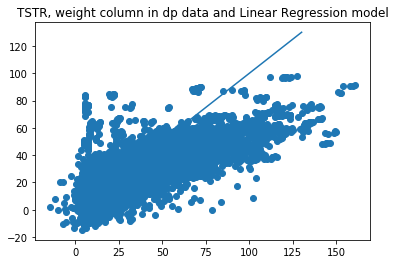

In [95]:
import matplotlib.pyplot as plt
plt.scatter(LR_dp_result['weight']['y_test'], LR_dp_result['weight']['y_pred'])
plt.plot([0,130],[0,130])
plt.title('TSTR, weight column in dp data and Linear Regression model')
plt.savefig('png_files/3.1 DWP/TSTR_weight_dp0814_LR.png')
plt.show()


## III. E Table
Table of $ E $ values for Linear Regression, Decision Tree Regression, Linear SVM and Random Forests models for real and synthetic data from DoppelGANger and TGANs.

In [96]:
com_t = Comparison_Table(synthetic_num_dic)
display(com_t)

'average MSE for each model and dataset'

/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: L

DoppelGANger_0814                    tGAN                tGAN_1  \
                   ori         gen         ori       gen         ori   
LR          404.700943  590.689031  241.889622  0.444488  164.767010   
DTR         769.202437  758.736782  326.611278  0.097403  374.777021   
SVM         452.233305  646.597482  260.657339  1.713456  180.616323   
RFR         403.926661  386.078829  223.457734  0.031489  245.136111   
KNR1        433.610385  482.900672  200.020197  0.777259  183.181984   
KNR5        433.610385  482.900672  200.020197  0.777259  183.181984   

                     tGAN_2            DoppelGANger_0824               \
            gen         ori        gen               ori          gen   
LR    13.087747  158.492706  13.407774       1506.689933  2385.723440   
DTR    1.233702  238.233516   0.312985       2596.974736  2520.285672   
SVM   24.526461  175.134803  25.759783       1607.039215  2742.328898   
RFR    0.618403  151.209596   0.165757       1827.250036  1277.469989   
KNR1   4.516420  163.892160   1.679422       1745.005741  1579.311150   
KNR5   4.516420  163.892160   1.679422       1745.005741  1579.311150   

          tGAN_4             
             ori        gen  
LR    154.744370  17.378768  
DTR   242.380602   0.466173  
SVM   235.404485  34.613487  
RFR   159.406387   0.213549  
KNR1  165.145240   1.500221  
KNR5  165.145240   1.500221

In [97]:
com_t.to_csv('csv_results/3.1 DWP/IIIE Table.csv')

#### For each synthetic data generator, plot the scatter graph of generated data MSE against original data with different prediction models. Ideally, these points should lie on the diagonal $ y=x $.

In [117]:
def Scatter_TSTS_TRTR(E_table):
    df_dic = list(set(E_table.keys().get_level_values(0).tolist()))
    models = (E_table.index).tolist()
    l = len(df_dic)
    for n in range(l):
        key = df_dic[n]
        plt.scatter(E_table[key,'ori'],E_table[key,'gen'],color='r')
        max_v = np.max(E_table[key,'ori'])
        plt.plot([0,max_v],[0,max_v])
        plt.xlabel('original')
        plt.ylabel('generated')
        plt.title(key)
        plt.savefig('png_files/3.1 DWP/scatter from IIIE Table '+ key+'.png')
        plt.show()

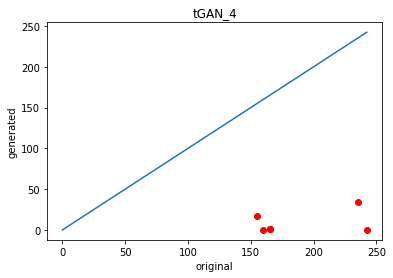

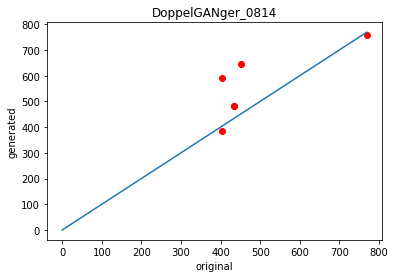

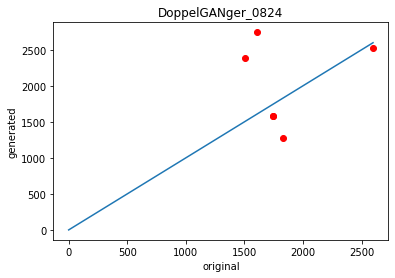

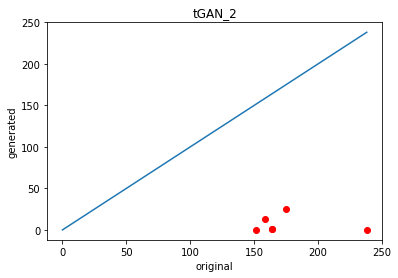

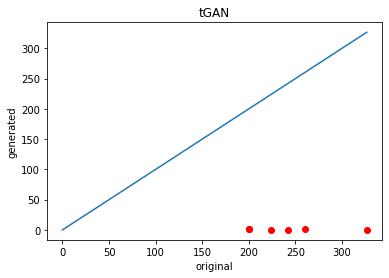

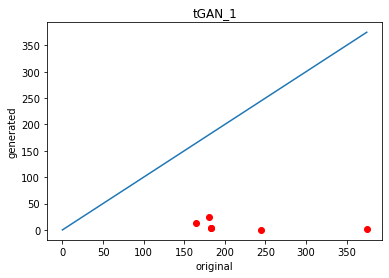

In [118]:
Scatter_TSTS_TRTR(com_t)

## Comment
We can see that models perform much better on synthetic data than the real data in the case of tGAN. This implies that the tGAN model may interpret the dependency between columns more simply (e.g. just take it as a linear relationship plus some noise) than it should be.

## SRA measuring E Table

In [98]:
def SRA_TSTS_TRTR(E_table):
    df_dic = list(set(E_table.keys().get_level_values(0).tolist()))
    models = (E_table.index).tolist()
    l = len(df_dic)
    v_np = np.zeros(l)
    for n in range(l):
        key = df_dic[n]
        v_np[n] = SRA(E_table[key,'ori'],E_table[key,'gen'])
    display('SRA for E table')
    return pd.Series(v_np,index = df_dic)

In [99]:
sra_E = SRA_TSTS_TRTR(com_t)
display(sra_E)
sra_E.to_csv('csv_results/3.1 DWP/sra_E.csv')

'SRA for E table'

tGAN_4               0.533333
DoppelGANger_0814    0.866667
DoppelGANger_0824    0.400000
tGAN_2               0.600000
tGAN                 0.466667
tGAN_1               0.200000
dtype: float64

### Comment
* DoppelGANger 0814 preserves the ranking of performance of different models pretty well, but there are only five columns within it. 
* tGAN_1 also preserves the ranking best among the others.

## IV. SRA measuring the list of MSEs for each column predicition results, for the specified model and synthetic data generator

In [100]:
def SRA_Comparison(df_dic,models = ['LR','DTR','SVM','RFR','KNR1','KNR5'] ):
    '''
    The dataframe values are TSTSvsTRTR SRAs which are ranking values for the accuracy of every columns, for the index model which is trained and tested on the column dataset.
    '''
    l = len(df_dic)
    v_np = np.zeros((len(models),l))
    keys = list(df_dic.keys())
    for n in range(l):
        k = keys[n]
        P1 = Prediction(df_dic[k][0])
        P2 = Prediction(df_dic[k][1])
        for m in range(len(models)):
            model = models[m]
            v_np[m][n] = SRA(P1.Evaluation_MSE(model),P2.Evaluation_MSE(model))
    display('SRA for column rankings')
    return pd.DataFrame(v_np,index = models, columns = keys)

       
    

In [101]:
sra_c = SRA_Comparison(synthetic_num_dic)
display(sra_c)

/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: L

'SRA for column rankings'

,DoppelGANger_0814,tGAN,tGAN_1,tGAN_2,DoppelGANger_0824,tGAN_4
LR,0.9,0.866667,0.866667,0.800000,0.933333,0.800000
DTR,0.8,0.800000,0.866667,0.800000,0.933333,0.733333
SVM,0.8,0.800000,0.866667,0.800000,0.933333,0.800000
RFR,0.8,0.800000,0.866667,0.800000,0.933333,0.733333
KNR1,0.7,0.866667,0.866667,0.866667,0.933333,0.866667
KNR5,0.7,0.866667,0.866667,0.866667,0.933333,0.866667


### Comment
There is no significant differences for different models or different synthetic data. The DoppelGANger_0824 gives the best result.

## V. Epsilon value tables

In [119]:
def Epsilon_Table(df_dic,models = ['LR','DTR','SVM','RFR','KNR1','KNR5'] ):
    '''
    The dataframe values are TSTSvsTRTR Epsilon values for the index model and column generator.
    '''
    from sklearn.metrics import mean_squared_error
    
    l = len(df_dic)
    v_np = np.zeros((len(models),l))
    keys = list(df_dic.keys())
    for n in range(l):
        k = keys[n]
        P1 = Prediction(df_dic[k][0])
        P2 = Prediction(df_dic[k][1])
        column_length = len((df_dic[k][0].keys()).tolist())
        for m in range(len(models)):
            model = models[m]
            v_np[m][n] = mean_squared_error(P1.Evaluation_MSE(model),P2.Evaluation_MSE(model))/column_length
    display('Epsilon value table')
    return pd.DataFrame(v_np,index = models, columns = keys)

In [120]:
EpsilonTable = Epsilon_Table(synthetic_num_dic)
EpsilonTable.to_csv('csv_results/3.1 DWP/EpsilonTable.csv')
display(EpsilonTable)

/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: L

'Epsilon value table'

,DoppelGANger_0814,tGAN,tGAN_1,tGAN_2,DoppelGANger_0824,tGAN_4
LR,13172.642119,14747.714031,109499.540776,15624.804542,5.658709e+05,14077.420829
DTR,26144.238526,45393.374348,181422.430086,48523.733814,5.381377e+04,139568.418018
SVM,5363.864646,18053.124875,111904.112237,17257.940617,1.269379e+06,20008.915093
RFR,5843.806185,34221.275903,124571.941320,26372.382873,3.218083e+05,88635.447241
KNR1,2860.641257,18913.387442,118325.996356,31795.821275,2.214248e+04,18405.546499
KNR5,2860.641257,18913.387442,118325.996356,31795.821275,2.214248e+04,18405.546499


### Comment
TGAN1 and DoppelGANger_0824 perform worse than the others.